In [1]:
import numpy as np
import math
from math import e
import pandas as pd
import qutip as qt
import random
from scipy.linalg import expm
import cmath

We must guarantee that any Hamiltonian used in this process is a Hermitian matrix (ensuring all the diagonal values are real numbers). A Hermitian matrix has the form:
<br>
    <h3>$$\begin{bmatrix}
    a & b + ic & d + ie & ...\\
    b - ic & f & g + ih & ...\\
    d - ie & g - ih & j & ...\\
    ... & ... & ... & ...
    \end{bmatrix}$$</h3>
<br>
To confirm the matrix is Hermitian, we use getH() to return the conjugate transpose of the matrix and then multiply $A \cdot A^{\dagger}$ and $A^{\dagger} \cdot A$. If the Hamiltonian is Hermitian, these products should be equivalent.

In [2]:
def check_hermitian(A):
    Adag = A.getH()
    if not (np.array_equal(np.matmul(Adag,A),np.matmul(A,Adag))):
        return False
    return True

In [3]:
def generate_hermitian(a,b,c,d):
    return np.matrix([[a,c+d*1j],[c-d*1j,b]])

This function works to create random Hermitian matrices of size $nxn$ which are then used as the Hamiltonian operator in the time evolution equation.  It first fills the entire matrix of complex numbers with zeros as place holders and then assigns each complex number a random value, mirroring this value with its complex conjugate.

In [4]:
def generate_random_hermitian(n):
    A = np.matrix(np.zeros((n,n),np.cdouble))
    constants = np.zeros(n*n)
    for i in range(0,n*n):
        constants[i] = random.random()
    constant_iter = 0
    for i in range(0,n-1):
        A[i,i] = constants[constant_iter]
        constant_iter += 1
        for j in range(i+1,n):
            A[i,j] = constants[constant_iter] + 1j*constants[constant_iter+1]
            A[j,i] = constants[constant_iter] - 1j*constants[constant_iter+1]
            constant_iter += 2
    A[n-1,n-1] = constants[constant_iter]
    return A

Below, we test our generate_random_hermitian function. We show that the generated matrix is indeed Hermitian and print out the random matrix.

In [5]:
dim = 5
A=generate_random_hermitian(dim)

In [6]:
check_hermitian(A)

True

In [7]:
A

matrix([[0.85632286+0.j        , 0.4967224 +0.49388476j,
         0.68940635+0.98988334j, 0.06141196+0.46311886j,
         0.20862108+0.77270366j],
        [0.4967224 -0.49388476j, 0.79364028+0.j        ,
         0.29205763+0.21282856j, 0.43688621+0.36307812j,
         0.07652405+0.37320367j],
        [0.68940635-0.98988334j, 0.29205763-0.21282856j,
         0.58551642+0.j        , 0.61807812+0.84062474j,
         0.60809978+0.58982349j],
        [0.06141196-0.46311886j, 0.43688621-0.36307812j,
         0.61807812-0.84062474j, 0.41773705+0.j        ,
         0.82378888+0.4603162j ],
        [0.20862108-0.77270366j, 0.07652405-0.37320367j,
         0.60809978-0.58982349j, 0.82378888-0.4603162j ,
         0.10849016+0.j        ]])

This function follows the following formula to give us the magnitude of the vector: $\sqrt{a_{0}^{2}+a_{1}^{2}+...+a_{n-1}^{2}}$. This allows us to normalize our vectors.

In [8]:
def get_magnitude(v):
    sum_of_squares = 0
    for i in v:
        sum_of_squares += i**2
    return cmath.sqrt(sum_of_squares)

This function is central to our program and performs the time evolution computation for a given Hamiltonian and initial state. The equation is as follows: 
<br>
<h2><center>$x(t)=e^{−iHt}x(0)$</center></h2>
<br>
Since the Hamiltonian is Hermitian, $-iHt$ will be skew-Hermitian, and therefore $e^{−iHt}$ will be Unitary, thus preserving the norm of $x(0)$.

In [9]:
def evolve(v,A,t):
    A = -A*1j*t
    A = expm(A)
    return np.matmul(A,v)

In [10]:
vec_2d = np.random.rand(2)
vec_2d = vec_2d/get_magnitude(vec_2d)
A_2d = generate_random_hermitian(2)

In an effort to verify the correctness of our results, we compared the evolved state generated by our function to the hardcoded two-dimensional expanded equation (16.78) found on page 391 of <i>"Quantum Mechanics"</i> by Eugen Merzbacher.  The equation is as follows:
<br>
<h2><center>$e^{-iHt} = \frac{\textit{I}}{E_2 - E_1} (E_2 e^{-iE_1t} - E_1 e^{-iE_2t}) + \frac{\textit{H}}{E_2 - E_1} (e^{-iE_2t} - e^{-iE_1t})$</center></h2>
We see that after an arbitrary seven timesteps, our evolve function yields the same value as the expanded equation.

In [11]:
timestep = 7
evolve(vec_2d,A_2d,timestep)

array([-0.31635203+0.05891599j,  0.56119324+0.76256963j])

In [12]:
e1 = np.linalg.eigvals(A_2d)[0]
e2 = np.linalg.eigvals(A_2d)[1]
I = np.matrix([[1+0*1j,0+0*1j],[0+0*1j,1+0*1j]])
term1 = I*(e2*e**(-e1*1j*timestep)-e1*e**(-e2*1j*timestep))/(e2-e1)
term2 = A_2d*(e**(-e2*1j*timestep)-e**(-e1*1j*timestep))/(e2-e1)

mat_exp = term1+term2 
np.matmul(mat_exp,vec_2d)

matrix([[-0.31635203+0.05891599j,  0.56119324+0.76256963j]])

This function executes $n$ timesteps of the evolution of the starting state $v$ using any Hamiltonian $A$.
As a result, the function returns $n$ state vectors as rows in a matrix.

In [13]:
def generate_evolution_matrix(v,A,n,t_step=1):
    evolution_matrix = np.array([v,evolve(v,A,t_step)])
    for i in range(2,n):
        evolution_matrix = np.vstack( (evolution_matrix,np.array([evolve(v,A,i*t_step)])) )
    return evolution_matrix

The code below effectively performs what we have set out to do. It randomly creates a Hamiltonian and initial state vector, then proceeds to generate the evolution data of the quantum system and separate the data into a matrix with four columns by its real and imaginary parts. For a two-dimensional complex vector $\begin{bmatrix}a+bi \\ c+di\end{bmatrix}$, $\mathbb{C}^{2}$ is represented in $\mathbb{R}^{4}$ as the row vector $\begin{bmatrix}a & b & c & d\end{bmatrix}$. Finally, we visualize the evolution of the quantum state on the three-dimensional Bloch sphere.

Hamiltonian:
 [[0.37408843+0.j        0.99346496+0.7767056j]
 [0.99346496-0.7767056j 0.24799253+0.j       ]]
Initial State:
 [0.61660963+0.j 0.78726905+0.j]


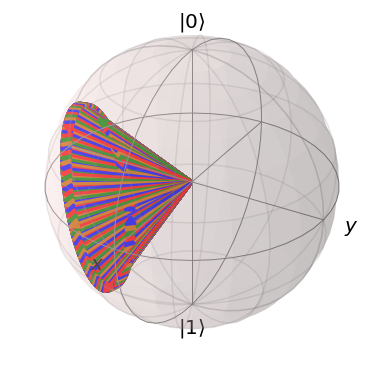

In [14]:
# choose random coefficients for hermitian hamiltonian
a=random.random()
b=random.random()
c=random.random()
d=random.random()
H = generate_hermitian(a,b,c,d)

# generate random 2 dimensional vector
initial_state = np.random.rand(2)

# change vector to have norm of 1
initial_state = initial_state/get_magnitude(initial_state)

# choose number of evolutions
num_rows = 1000
evolution_matrix = generate_evolution_matrix(initial_state,H,num_rows)

#extract real and imaginary parts out of evolution matrix
split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
for row in range(0,evolution_matrix.shape[0]):
    split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
    split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
    split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
    split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])

#visualize on bloch sphere
b = qt.Bloch()
state_matrix = np.empty(num_rows, dtype=qt.Qobj)
for i in range(0,num_rows):
    state_matrix[i] = qt.Qobj(evolution_matrix[i])
b.add_states(state_matrix)
b.render()

# print hamiltonian and initial vector
print("Hamiltonian:\n",H)
print("Initial State:\n",initial_state)

The function below performs the same actions as the above code block except it exports the resulting matrices as csv files for ease of analysis.

In [15]:
# unspecified dimension defaults to 2x2 hamiltonian
def generate_data_2d(filename,ham_filename,num_evolutions,H=None,t_step=1):
    # choose random coefficients for hermitian hamiltonian
    #if one is not provided by H
    if type(H) != np.ndarray():
        a=random.random()
        b=random.random()
        c=random.random()
        d=random.random()
        H = generate_hermitian(a,b,c,d)

    # generate random 2 dimensional vector
    #Want to sample [-1,1), so first sample
    #[0,2) then shift down by 1
    vec = 2*np.random.rand(2)-1

    # change vector to have norm of 1
    vec = vec/get_magnitude(vec)

    # choose number of evolutions
    num_rows = num_evolutions
    evolution_matrix = generate_evolution_matrix(vec,H,num_rows,t_step=t_step)

    #extract real and imaginary parts out of evolution matrix
    split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
    for row in range(0,evolution_matrix.shape[0]):
        split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
        split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
        split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
        split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
    # export data as csv
    mat_df = pd.DataFrame(split_evolution_matrix)
    mat_df.to_csv(filename)
    ham_df = pd.DataFrame(H)
    ham_df.to_csv(ham_filename)

This next function generalizes the proces of its two-dimensional counterpart to allow us to specify any dimensionality for the $nxn$ Hamiltonian and the initial state vector.

In [16]:
# generalization for any dimensionality
def generate_data(filename,ham_filename,num_evolutions,dim,t_step=1):
    H = generate_random_hermitian(dim)
    vec = np.zeros(dim,np.cdouble)
    vec[0] = 1+0*1j
    evolution_matrix = generate_evolution_matrix(vec,H,num_evolutions,t_step)

    #extract real and imaginary parts out of evolution matrix
    split_evolution_matrix = np.zeros((evolution_matrix.shape[0],dim*2))
    for row in range(0,evolution_matrix.shape[0]):
        for i in range(0,dim):
            split_evolution_matrix[row,2*i] = np.real(evolution_matrix[row,i])
            split_evolution_matrix[row,2*i+1] = np.imag(evolution_matrix[row,i])
    
    # export data as csv
    mat_df = pd.DataFrame(split_evolution_matrix)
    mat_df.to_csv(filename)
    ham_df = pd.DataFrame(H)
    ham_df.to_csv(ham_filename)

We now run our two-dimensional function 30 times with 3000 timesteps per Hamiltonian. We also generate 1000 timesteps of evolution data for a 50x50 Hamiltonian.

In [17]:
for i in range(1,31):
    filename = "data/evolution_data/evolution_data" + str(i) + ".csv"
    ham_filename = "data/hamiltonians/hamiltonian" + str(i) + ".csv"
    generate_data_2d(filename,ham_filename,3000)

In [18]:
generate_data("evolution_data.csv","hamiltonian.csv",1000,50)